# Phase 1 : Exploring the Data from the Seasons of Game of Thrones
## Question:  How are the narrative importance of Stark and Lannister main characters in the series?

Examining how the csv files are organized , we see a separation between a table of all the characters(nodes.csv) and
a table of all the relationships of those characters (edges.csv)

In the s1_edges dataframe: the 'Source' & 'Target' columns are the character nodes in the interactions and the 'Weight' column is the number of interactions by them in the scenes of the season.

There are five interaction types. Character A and Character B are connected when:

1. Character A speaks directly after Character B
2. Character A speaks about Character B
3. Character C speaks about Character A and Character B
4. Character A and Character B are mentioned in the same stage direction
5. Character A and Character B appear in a scene together


In the s1_nodes dataframe: the 'Id' is the character name and 'Label' appears to be a casual version that the character is referenced by in the series. 

In [1]:
import pandas as pd 
import networkx as n
import matplotlib.pyplot as plt 
import numpy as np
from scipy.stats import skew

# Read in the csv files for season 1: season 1 edges and season 1 nodes
s1_edges = pd.read_csv('gameofthrones/data/got-s1-edges.csv')
s1_nodes = pd.read_csv('gameofthrones/data/got-s1-nodes.csv')

# Examine the first 5 rows of edges to get an idea of the columns and rows
print(s1_edges.head(5), '\n')

# Examine the first 5 rows of nodes to get an idea of the columns and rows
print(s1_nodes.head(5))

         Source  Target  Weight  Season
0           NED  ROBERT     192       1
1      DAENERYS   JORAH     154       1
2           JON     SAM     121       1
3  LITTLEFINGER     NED     107       1
4           NED   VARYS      96       1 

               Id     Label
0  ADDAM_MARBRAND     Addam
1           AEGON     Aegon
2           AERYS     Aerys
3  ALLISER_THORNE  Allister
4            ARYA      Arya


## Define Narrative Importance:

Since the main goal involves measuring narrative importance , we need to define what measuring narrative importance means. Every character in the edge dataframe is assigned to a target character and a corresponding Weight of the amount of scene interactions, so we can use that weight value. We will use this value in 2 specific ways. 

The first way we will use the value is by counting the number of occurrences of it to use as the number of characters that character has interacted with. The second way is by summing all the weights for each character to use as the total number of interactions per character. The former gives us an idea of how much connections a character has in the story-- narrative connections , and the latter gives us an idea how much plot focuses on a character-- narrative focus. Both of which together we will use to measure narrative importance.

## The Pre-Process: 

### Creating the concat dataframe
To start we will need to split the edges dataframe into 2 dataframes and duplicate the 'Weight' column. We do this because of the bi-directional nature of an interaction. Neither the 'Source' column nor 'Target' column by themselves reflect every character interaction in the show. Then we take the 2 new dataframes and concat them to create a new dataframe that we will use for all our future analysis. 

To test that it was appended correctly we will filter for the first 2 rows of the original dataframe: 192 and 154 interactions respectfully. This shows us that data frame 1 was included first with 'Ned' and 'Daenerys' indexed at 0 and 1. Then dataframe 2 shows up all the way after the length of dataframe 1 with 'Robert' and 'Jorah' indexed at 550 and 551. 

In [2]:
# Create identical column names and set the character id as index for manipulation
s1_edges_index = s1_edges.rename(columns={'Source':'Id'}).set_index('Id')
s1_nodes_index = s1_nodes.set_index('Id')

print(s1_edges_index.head(2)) 

# Seperate the edges dataframe 'Source' & 'Target' columns into 2 dataframes, 
# copying the 'Weight' column for both 'Source' & 'Target' characters
df_2 = s1_edges_index[['Target','Weight']].reset_index().drop(['Id'], axis=1).rename(columns={'Target':'Id'})
df_1 = s1_edges_index[['Weight']].reset_index()
# Concat the 2 dataframes together to have 1 dataframe that accounts every interaction from 'Source' & 'Target'
lis = pd.concat([df_1 , df_2], sort=False, ignore_index=True)
print(lis.loc[lis['Weight']==192] , '\n', lis.loc[lis['Weight']==154] )


          Target  Weight  Season
Id                              
NED       ROBERT     192       1
DAENERYS   JORAH     154       1
         Id  Weight
0       NED     192
550  ROBERT     192 
            Id  Weight
1    DAENERYS     154
551     JORAH     154


### Organize by sum and count 
Now that the main dataframe is created , we can group all the characters in it by both Sum and Count. And put the results in new dataframes called df_sum and df_count. We will manipulate the Sum dataframe to measure narrative focus and the Count dataframe to measure narrative connections. As you can see the dataframes df_sum & df_count are a list of unique characters with the corresponding Sum or Count total. 

In [3]:
# Group the dataframe by the sum of all interactions per character
df_sum = lis.groupby(lis.Id)['Weight'].sum()
# Group the dataframe by the count of characters interacted 
df_count = lis.groupby(lis.Id)['Weight'].count()
print(df_sum.head(5) ,'\n', df_count.head(5))

Id
ADDAM_MARBRAND      8
AEGON               4
AERYS              41
ALLISER_THORNE     73
ARYA              373
Name: Weight, dtype: int64 
 Id
ADDAM_MARBRAND     3
AEGON              2
AERYS             13
ALLISER_THORNE     8
ARYA              28
Name: Weight, dtype: int64


## Stat Analysis of Dataframes:
### Measure distributions: skew , median and mean

Now let's view the distribution of all sum and count interactions. Even without checking the numbers you can see the distributions are skewed to the right. But we can confirm this by calculating the skew. Keeping in mind anything greater than 1 is highly skewed right, we find our df_sum is greater than 3 and our df_count is greater than 2. This means the mean is greater than the median due to a couple of large values that push the mean higher. 

In terms of the story this skew means the season operates with a few characters getting most of the interactions and spotlight. These characters are clearly main characters, with anything lower than these extreme values likely being different levels of side characters. The median which is unaffected by outliers gives us the clearest picture of the behavior of a typical side character. They had around 31 interactions on screen and interacted with around 6 characters. We care about the far right of our distributions to focus our analysis on the main characters. Let’s use the top 5% of total interactions and number of characters interacted to indicate major characters in a season.


	Skew
Sum:  3.4116588193958335  Count:  2.1968309865667


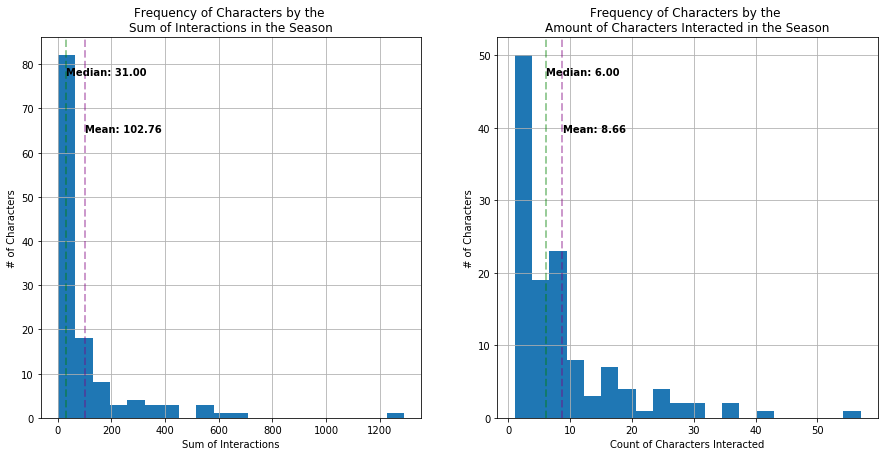

In [4]:
# The skew is greater than 1 so it is highly skewed to the right
print('\tSkew\nSum: ', skew(df_sum),' Count: ', skew(df_count))


# Create a histograph to see the distribution of the Sum and Count dataframes
plt.subplot(121)
plt.title('Frequency of Characters by the \nSum of Interactions in the Season')
df_sum.hist(figsize=(15, 7), bins=20) 
plt.axvline(df_sum.mean(), color='purple', linestyle='dashed', linewidth=2, alpha=.4)
plt.axvline(df_sum.median(), color='green', linestyle='dashed', linewidth=2, alpha=.4)
plt.ylabel('# of Characters')
plt.xlabel('Sum of Interactions')
_, max_ = plt.ylim()
plt.text(df_sum.mean() + df_sum.mean()*.01, max_ - max_*.25, 'Mean: {:.2f}'.format(df_sum.mean()), weight='bold')
plt.text(df_sum.median() + df_sum.median()*.01 , max_-max_*.1 ,'Median: {:.2f}'.format(df_sum.median()), weight='bold')



plt.subplot(122)
plt.title('Frequency of Characters by the \nAmount of Characters Interacted in the Season')
df_count.hist(figsize=(15, 7), bins=20)
plt.axvline(df_count.mean(), color='purple', linestyle='dashed', linewidth=2, alpha=.4)
plt.axvline(df_count.median(), color='green', linestyle='dashed', linewidth=2, alpha=.4)
plt.ylabel('# of Characters')
plt.xlabel('Count of Characters Interacted')
_, max_ = plt.ylim()
plt.text(df_count.mean() + df_count.mean()*.01, max_ - max_*.25, 'Mean: {:.2f}'.format(df_count.mean()), weight='bold')
plt.text(df_count.median() + df_count.median()*.01 , max_-max_*.1 ,'Median: {:.2f}'.format(df_count.median()), weight='bold')
plt.show()


### Filtering using the stats
Now let's filter and sort our values to learn the names of our most important characters.  First we will calculate the 95 percentile of our df_sum and df_count. We will round the 95 percentiles down and then add 1 to the resulting numbers to give us the lower border of the top 5% range for the amount of total interactions and characters interacted. We round down the numbers because an interaction or character cannot be a decimal number. We add 1 because one value above the 95 percentile starts the top 5%.

For example: For df_sum the bottom 95% of total interactions end at 437.99 interactions. Then we round down to get the value of 437 interactions or higher for the top 5%. Last by adding 1 to this value we learn that the lower border for the top 5% of total interactions is 438.  The same method applied to df_count gives us the true lower border value of 28 characters interacted or higher for the top 5%.

### Insights
When we filter those values into our dataframes we get the list of characters for the top 5%. It seems like the two dataframes contain allot of the same characters, but in a different order. My theory is the different order exists because of the isolation of certain important characters from the central conflict of the season. As well as certain less focused on characters who are part of the central Lannister-Stark conflict and so interact with an unusually high amount of characters for their current focus in the plot. To support my theory I will explain the character differences.


Cersei is on both lists in a different rank order. She is 5th on the Count dataframe and 6th on the Sum dataframe. This I believe is a consequence of all the other additions to the Sum dataframe. Jon and Daenerys are both on the Sum dataframe and not on the Count Dataframe. This abnormality is due to the isolation of their narratives compared to everyone else. Robb and Arya are similarly only on the Count dataframe, they are both future main characters entangled in the central Stark-Lannister conflict despite not being focused on heavily in the narrative yet. This is probably why they have a high number of characters interacted. 



In [5]:
# Calculate the 95th percentile to find where the top 5% of all summed interactions start
# Then filter the dataframe using that information to list the characters involved 
print('Top 5% of total interactions were {:0.0f} interactions or higher \n'.format
      ((np.floor(df_sum.quantile(.95))+1)))

Top5_Sum=df_sum.loc[lambda x:x>=np.floor(df_sum.quantile(.95))+1].sort_values(ascending=False).reset_index()
print('This top 5% involves the following characters: \n',Top5_Sum)


Top 5% of total interactions were 438 interactions or higher 

This top 5% involves the following characters: 
          Id  Weight
0       NED    1290
1    TYRION     708
2   CATELYN     584
3    ROBERT     563
4       JON     535
5  DAENERYS     535
6    CERSEI     444


In [6]:
# Calculate the 95th percentile to find where the top 5% of all counted interactions start
# Then filter the dataframe using that information to list the characters involved 
print('Top 5% of total characters interacted were {:0.0f} number of characters interacted or higher \n'.format
      ((np.floor(df_count.quantile(.95))+1)))
Top5_Count = df_count.loc[lambda x:x>=np.floor(df_count.quantile(.95)+1)].sort_values(ascending=False).reset_index()
print('This top 5% involves the following characters: \n',Top5_Count)


Top 5% of total characters interacted were 28 number of characters interacted or higher 

This top 5% involves the following characters: 
         Id  Weight
0      NED      57
1   TYRION      41
2  CATELYN      37
3   ROBERT      36
4     ROBB      30
5   CERSEI      29
6     ARYA      28


### Filtering only the Lannisters and Starks
Now that we know the stats we are using to filter the characters and the results we get from doing so , let's now focus on just the main characters that are Lannisters and Starks. For our analysis , we will only define Lannisters and Starks to be the members of the family that would potentially be on the far right of the distribution. No side characters.

In [7]:
# Filter Top5_Count for Starks and Lannisters 
Lannisters = ['TYRION','TYWIN','CERSEI','JAIME']
Starks = ['NED', 'CATELYN', 'ROBB','JON','SANSA','ARYA']
Main_Char = Lannisters + Starks
Top_LanC = Top5_Count[Top5_Count['Id'].isin(Lannisters)]
Top_StarC = Top5_Count[Top5_Count['Id'].isin(Starks)]
print('Top 5 Lannisters Ranks\n',Top_LanC,'\n', Top_StarC)
print()
Top_LanS = Top5_Sum[Top5_Sum['Id'].isin(Lannisters)]
Top_StarS = Top5_Sum[Top5_Sum['Id'].isin(Starks)]
print('Top 5 Starks Ranks\n',Top_LanS,'\n', Top_StarS)


Top 5 Lannisters Ranks
        Id  Weight
1  TYRION      41
5  CERSEI      29 
         Id  Weight
0      NED      57
2  CATELYN      37
4     ROBB      30
6     ARYA      28

Top 5 Starks Ranks
        Id  Weight
1  TYRION     708
6  CERSEI     444 
         Id  Weight
0      NED    1290
2  CATELYN     584
4      JON     535


## Create & Filter for Seasons 1-7:

### Create the function
Now let's turn what we have done so far into a function and compare the Lannister & Stark characters throughout the seasons. We can see how important each character was for each season.


In [8]:
def ranking(df, isSum):
    # Extract Target & Source columns with the assigned Weights
    # Rename the Target & Source column name into Id
    df2 = df[['Target','Weight']].rename(columns={'Target':'Id'})
    df1 = df[['Source','Weight']].rename(columns={'Source':'Id'})
    # Concat the 2 dfs 
    df_main = pd.concat([df2 , df1], sort=False, ignore_index=True)
    # If True use Sum function else use Count function
    if isSum:
        df_groupby = df_main.groupby(df_main.Id)['Weight'].sum()
    else:
        df_groupby = df_main.groupby(df_main.Id)['Weight'].count()
    # Calculate the interaction Sum or Count number that is the 95 percentile of the interaction range   
    percentile95 = np.floor(df_groupby.quantile(.95))+1 
    # Filter the interaction range for that 95 percentile number or larger to get the top 5% and Sort them
    Top5=df_groupby.loc[lambda x:x>=percentile95].sort_values(ascending=False).reset_index()
    # Filter the characters for Lannisters & Starks
    Top5 = Top5[Top5['Id'].isin(Main_Char)]
    # Fix index so that it represents ranks 1 through 6
    Top5.index = np.arange(1, len(Top5)+1)
    # Create a dictionary using both character names and their rank
    pairs = dict(zip(Top5['Id'],Top5.index))
    return pairs


### Apply the function to prepare for visualization

In [9]:
# Using techniques on Season 1-7. Finding and comparing the Sum and Count rankings of the 
# top 1% of characters in each season
seasons = ['gameofthrones/data/got-s1-edges.csv','gameofthrones/data/got-s2-edges.csv', 'gameofthrones/data/got-s3-edges.csv','gameofthrones/data/got-s4-edges.csv', 
 'gameofthrones/data/got-s5-edges.csv', 'gameofthrones/data/got-s6-edges.csv', 'gameofthrones/data/got-s7-edges.csv']

season1to7_Sum = {}
season1to7_Count = {}
for i , s in enumerate(seasons, start=1): 
    edges = pd.read_csv(s) 
    a = ranking(edges, True)
    b = ranking(edges, False)
    season1to7_Sum[i]=a
    season1to7_Count[i]=b
# Turn dictionaries into DataFrames and turn NAN into 10 ( > Rank 8 = Irrelevant )
df_rank_S_pre = pd.DataFrame(season1to7_Sum).fillna(10)
df_rank_C_pre = pd.DataFrame(season1to7_Count).fillna(10)
# Apply function to dataframes to turn <10 into 1 and 10 into 0
df_rank_C = df_rank_C_pre.applymap(lambda s: 1 if s<10 else 0 )
df_rank_S= df_rank_S_pre.applymap(lambda s: 1 if s<10 else 0 )
# Create a list that assigned colors red or blue depending on if Lannister or Starks
color = ['r' if n in Lannisters else 'b' for n in df_rank_S.index]

As you can see the function originally gives us a dataframe for both Sum and Count that displays the rank of the characters between 1 to 6. For any season where I character does not land on the top 5% we fill that in with a 10.

For plotting purposes we will not be visualizing this format we will be counting how many times a character reaches the top 5%. The reasons is for our purposes reaching the top 5% in any order is the important indication for narrative focus and narrative connections, and it is easier to compare the counts. This will be achieved by filling in a 0 for any place a 10 is and turning the rest into 1. 


In [17]:
print('--Count--\n',df_rank_C_pre, '\n', '\n--Sum--\n',df_rank_S_pre)

--Count--
             1     2     3     4     5     6     7
ARYA      6.0   4.0  10.0  10.0  10.0  10.0  10.0
CATELYN   3.0   6.0   4.0  10.0  10.0  10.0  10.0
CERSEI    5.0   2.0   5.0   2.0   1.0   3.0   3.0
JAIME    10.0  10.0  10.0   5.0  10.0   5.0  10.0
JON      10.0  10.0  10.0   4.0   2.0   2.0   1.0
NED       1.0  10.0  10.0  10.0  10.0   6.0  10.0
ROBB      4.0   3.0   1.0  10.0  10.0  10.0  10.0
SANSA    10.0  10.0  10.0   3.0   3.0   1.0  10.0
TYRION    2.0   1.0   3.0   1.0  10.0   4.0   2.0
TYWIN    10.0   5.0   2.0   6.0  10.0  10.0  10.0 
 
--Sum--
             1     2     3     4     5     6     7
ARYA     10.0   3.0  10.0  10.0  10.0   6.0  10.0
CATELYN   3.0  10.0  10.0  10.0  10.0  10.0  10.0
CERSEI    5.0   2.0   5.0   2.0   1.0   5.0   3.0
JAIME    10.0  10.0   6.0   3.0  10.0   4.0  10.0
JON       4.0  10.0   7.0   5.0   2.0   1.0   1.0
NED       1.0  10.0  10.0  10.0  10.0  10.0  10.0
ROBB     10.0   4.0   2.0  10.0  10.0  10.0  10.0
SANSA    10.0  10.0   4.0  

In [11]:
print('The number of times each character reached the top 5% \nfor each seasons in number of characters interacted:\n',df_rank_C)
print()
print('The number of times each character reached the top 5% \nfor each seasons in number of total interactions:\n',df_rank_S)

The number of times each character reached the top 5% 
for each seasons in number of characters interacted:
          1  2  3  4  5  6  7
ARYA     1  1  0  0  0  0  0
CATELYN  1  1  1  0  0  0  0
CERSEI   1  1  1  1  1  1  1
JAIME    0  0  0  1  0  1  0
JON      0  0  0  1  1  1  1
NED      1  0  0  0  0  1  0
ROBB     1  1  1  0  0  0  0
SANSA    0  0  0  1  1  1  0
TYRION   1  1  1  1  0  1  1
TYWIN    0  1  1  1  0  0  0

The number of times each character reached the top 5% 
for each seasons in number of total interactions:
          1  2  3  4  5  6  7
ARYA     0  1  0  0  0  1  0
CATELYN  1  0  0  0  0  0  0
CERSEI   1  1  1  1  1  1  1
JAIME    0  0  1  1  0  1  0
JON      1  0  1  1  1  1  1
NED      1  0  0  0  0  0  0
ROBB     0  1  1  0  0  0  0
SANSA    0  0  1  1  1  1  0
TYRION   1  1  1  1  1  1  1
TYWIN    0  0  1  1  0  0  0


## Graph Visualizing Sum

After applying the function we first get a bar chart plot of the number of seasons each Stark and Lannister is in the top 5% for the total interactions for each respective season. Starks are in blue and Lannisters are in red. As a reminder interactions also account for a charact talking about another or have the 2 characters mentioned together. So it is possible to have interactions while being dead in the story.

As you can see there are less Lannisters than Starks, even if we only focus on those that are alive after season 7. Despite this , the Lannisters dominate top 5% in total interactions. Cersei and Tyrion are the only characters of them all to always be present on the top 5% for every season. The highest Stark is Jon who is only in the top 5% for 6 out of the 7 seasons. The lowest Lannister Tywin reaches the top 5% for 2 out of 7 seasons , while the lowest Starks Ned & Catelyn reach the top 5% for only 1 out of 7 seasons.

Considering that in a T.V series every interaction should move the plot in some way or develop the characters it can be suggested that while we follow more of the Starks it is the Lannisters that are the narrative focus and truly develop the plot. The dynamic between Tyrion who is usually considered a good guy and Cersei who is usually the antithesis to Tyrion seems to get more scenes than the Stark and Lannister conflict. Hence just by number of scenes the main protagonist would be Tyrion and the antagonist would be Cersei. But lets look at number of characters interacted before making that judgment.



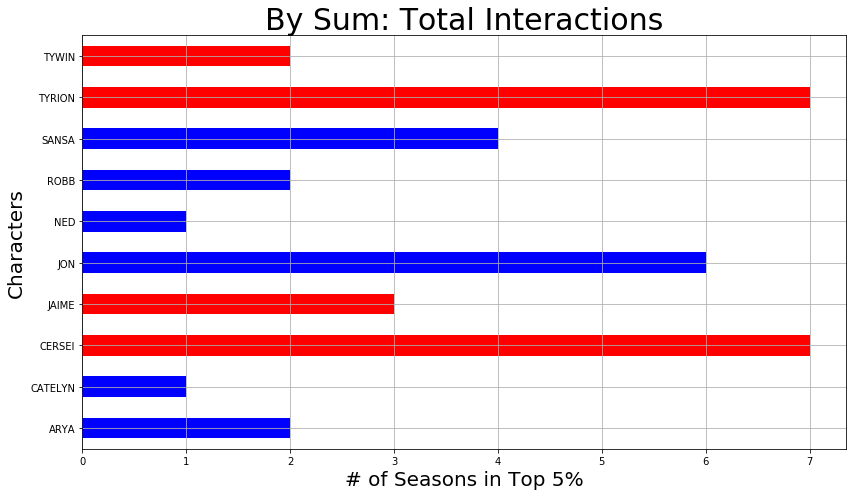

In [12]:
#  Plot the Transpose of df_rank_S to create a bar plot 
plt.figure(figsize=(12,7))
plt.title('By Sum: Total Interactions', fontsize=30)
plt.xlabel('# of Seasons in Top 5%',fontsize=20)
plt.ylabel('Characters',fontsize=20)
df_rank_S.T.sum().plot(kind='barh', color=color)
plt.grid()
plt.tight_layout()
plt.show()
  


## Visualizing Count

After applying the function we first get a bar chart plot of the number of seasons each Stark and Lannister is in the top 5% for the number of characters interacted with for each respective season. Again Starks are in blue and Lannisters are in red. Cersei again is on the top 5% for all 7 seasons and this time she beats even Tyrion by 1 season. They both beat the highest Stark Jon , who only reaches the top 5% for 4 out of the 7 seasons. However, this time on the lower spectrum Jaime , Arya and Ned share the lowest seasons on the top 5% at 2 seasons. The last Lannister Tywin is also even with rest of the Starks: Catelyn , Robb and Sansa. 

Considering the number of narrative connections that character has can suggest a characters influence in the story. It is possible to have low narrative focus but high influence, and visa vi. A classic example of this dynamic is in the first few Harry Potter books most main characters have a higher narrative focus than Lord Voldemort , but his influence is not measured by how many scenes he is in or how many times 1 character talks about him. It is measured by how many characters talk about him. That makes Lord Voldemort an influential character with many narrative connections even when he is not personally developing each plot.

Using this plot we can see that allot of characters have the same number of seasons of comparably high narrative connections. With some like Ned having more top 5% seasons in connections & influence than they have seasons alive. Another interesting fact can be seen when you consider how long each character was alive. Catelyn and Robb were only alive for 3 seasons and still developed as much or more seasons in the top 5% for narrative connections than Sansa and Arya. Both of which are still alive in Season 7. Hence besides Jon most Starks just have not developed high narrative connections throughout seasons consistently or those that did died early in the story. Again the Lannisters Cersei and Tyrion are the most influential in the story with Jon being a far third. 



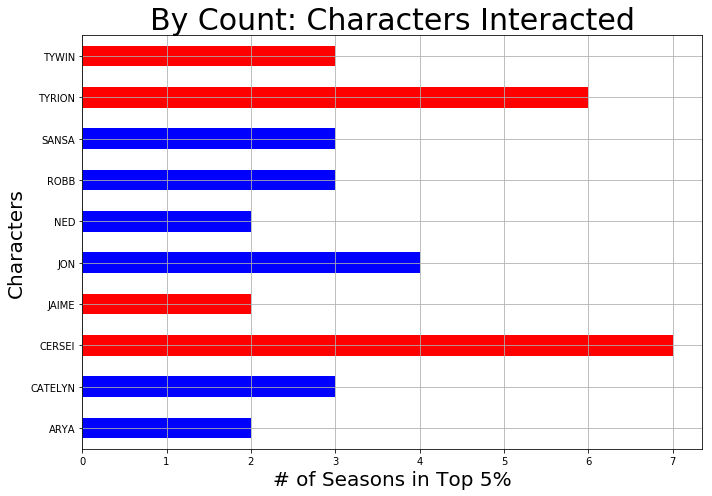

In [13]:
#  Plot the Transpose of df_rank_C to create a bar plot 
plt.figure(figsize=(10,7))
plt.title('By Count: Characters Interacted',fontsize=30)
plt.xlabel('# of Seasons in Top 5%', fontsize=20)
plt.ylabel('Characters',fontsize=20)
df_rank_C.T.sum().plot(kind='barh', color=color)
plt.grid()
plt.tight_layout()
plt.show()


## Conclusion

The main characters of the highest narrative importance are Tyrion and Cersei for the Lannisters. And Jon for the Starks. --give more reasons--

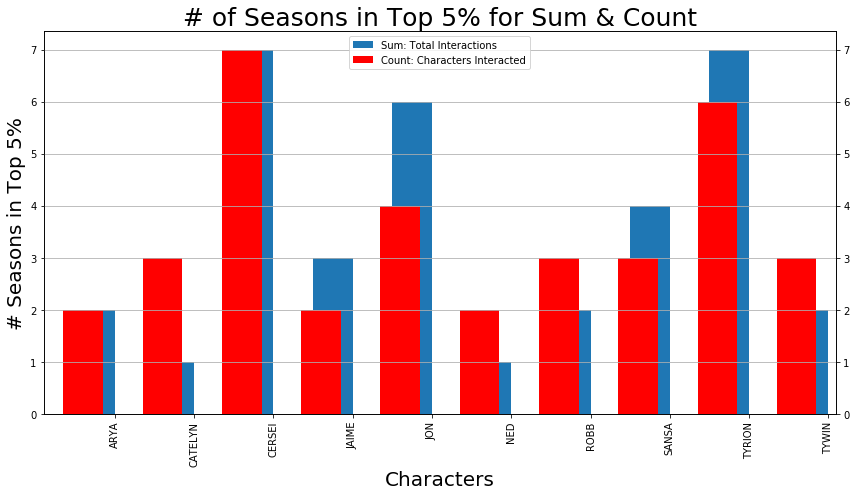

In [16]:
counted= df_rank_C.T.sum() 
summed= df_rank_S.T.sum() 
fig = plt.figure(figsize=(12,7))
plt.title('# of Seasons in Top 5% for Sum & Count', fontsize=25)
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax.set_xlabel('Characters' , fontsize=20)
ax.set_ylabel('# Seasons in Top 5%', fontsize=20)
summed.plot(kind='bar',  ax=ax, position=1, label='Sum: Total Interactions')
counted.plot(kind='bar', ax=ax2, color='r',position=1.3, label='Count: Characters Interacted')
h1,l1 =ax.get_legend_handles_labels()
h2, l2=ax2.get_legend_handles_labels()
plt.legend(h1+h2,l1+l2, loc='upper center' )
plt.grid()
plt.tight_layout()
plt.show() 